In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

MessageError: ignored

In [ ]:
%cd /content/gdrive/MyDrive/SLIIT/Research Project/

/content/gdrive/MyDrive/SLIIT/Research Project


In [ ]:
#import relevant libraries
import numpy as np
import pandas as pd

#import the csv file to extract data
df=pd.read_csv('Money printing data.csv')
df=df.dropna() #drop null values
print('Shape of data',df.shape)
df.info()
df.head()

Shape of data (325, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Month                                       325 non-null    object
 1   Net Credit granted to the Government (NCG)  325 non-null    object
dtypes: object(2)
memory usage: 7.6+ KB


,Month,Net Credit granted to the Government (NCG)
0,Dec-95,"38,662"
1,Jan-96,"40,795"
2,Feb-96,"40,238"
3,Mar-96,"43,617"
4,Apr-96,"43,090"


We have to convert the 'Net Credit granted to the Government (NCG)' column's datatype into float.

In [ ]:
# define a function to remove comma and convert to float
def remove_comma_and_convert_to_float(s):
    s = s.replace(',', '')
    f = float(s)
    return f


#apply the function to the entire column 
df['Net Credit granted to the Government (NCG)'] = df['Net Credit granted to the Government (NCG)'].apply(remove_comma_and_convert_to_float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Month                                       325 non-null    object 
 1   Net Credit granted to the Government (NCG)  325 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [4]:
dup_sum=df.duplicated(subset='Month').sum()
print(dup_sum)

sum_null = df.isnull().sum()
print(sum_null)


NameError: ignored

No duplicates or null values in the dataset.

Now we have to test whether the data set is stationary or not. Use Augmented Dick-fuller (ADF) for that.

    null hypotheis : the series is non-stationary
    alternative hypothesis : the series is stationary


In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['Net Credit granted to the Government (NCG)'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.317868
p-value: 1.000000


As the p-value is greater than 0.05, the null hypothesis cannot be rejected at a significant level of 95%. So the tme series is not stationary.

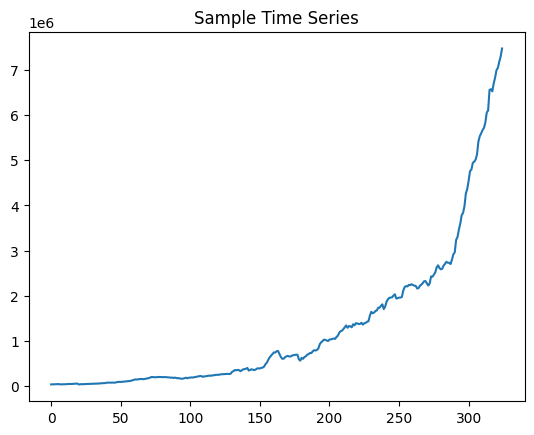

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# plot the time series
plt.plot(df['Net Credit granted to the Government (NCG)'])
plt.title('Sample Time Series')
plt.show()

As the time series is non-stationary, let us differentiate it.

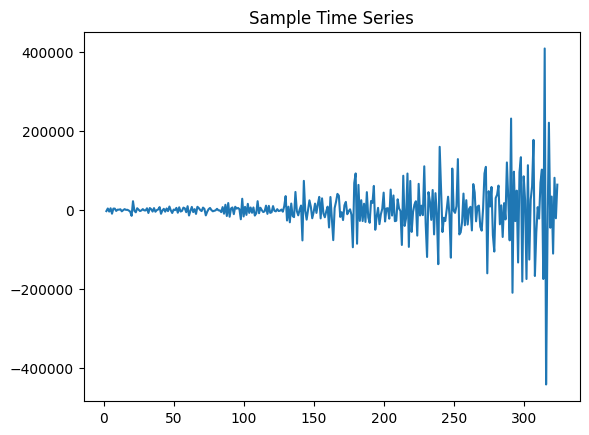

In [ ]:
diff_df = df['Net Credit granted to the Government (NCG)'].diff().diff()

# drop the first row (since it will have NaN value after differencing)
diff_df.dropna(inplace=True)

# plot the differentitated time series
plt.plot(diff_df)
plt.title('Sample Time Series')
plt.show()

Lets do the ADF test & check the stationarity again.

In [ ]:
result = adfuller(diff_df.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.900694
p-value: 0.000000


Lets check whether there is any seasonality in the differentiated time series.

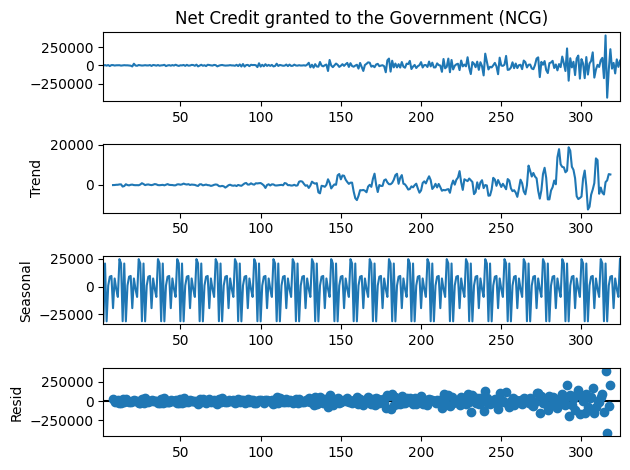

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition using moving averages
decomposition = seasonal_decompose(diff_df, model='additive', period=12)

# Plot the seasonal decomposition
fig = decomposition.plot()

There is a seasonal component because we can see a repeating pattern in seasonal component.

Residual distribution has no patterns & its random. So thats not a problem.

No trend. 

So, now to remove the seasonality, lets use SARIMA. Before that we need to identify the exact seasonal period of the time series. lets plot the ACF & PACF plots in order to do that.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


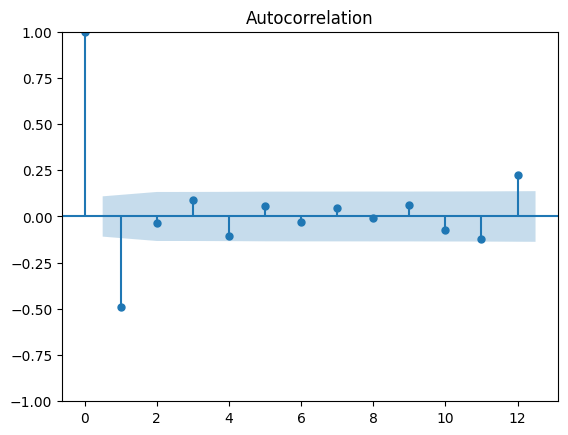

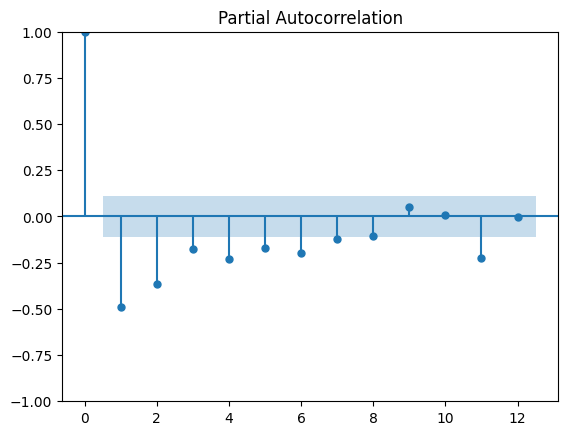

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# assuming your data is stored in a pandas dataframe df, with a datetime index
seasonal_period = 12
#fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(diff_df, lags=12)
plot_pacf(diff_df, lags=12)
plt.show()


As the significant lags appear at 1 & 12, the seasnal period can be taken as 12. if the PACF contains 12 significnat spikes, thats a strng indicatin that the seasnal period is 12. But here, we can only see 8 significant spikes.  

Using these two plots, SARIMA parameters can be determined. 

SARIMA (8,2,2)(0,2,1,12) since ACF plot has random significant spikes.

NOw let us train the SARIMAX model.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

train, test = train_test_split(diff_df, test_size=0.2, shuffle=False)

model = SARIMAX(train, order=(8,2,2), seasonal_order=(0,2,1,12))
fitted_model = model.fit()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible start

In [ ]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     Net Credit granted to the Government (NCG)   No. Observations:                  258
Model:                       SARIMAX(8, 2, 2)x(0, 2, [1], 12)   Log Likelihood               -2842.184
Date:                                        Mon, 08 May 2023   AIC                           5708.369
Time:                                                11:17:35   BIC                           5749.729
Sample:                                                     0   HQIC                          5725.049
                                                        - 258                                         
Covariance Type:                                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.4023      0.196    -12.235      0.000      -2.787      -2.018
ar.L2         -3.0051      0.509     -5.902      0.000      -4.003      -2.007
ar.L3         -2.8940      0.826     -3.502      0.000      -4.514      -1.274
ar.L4         -2.5112      0.986     -2.546      0.011      -4.445      -0.578
ar.L5         -2.1520      0.965     -2.230      0.026      -4.043      -0.261
ar.L6         -1.7589      0.797     -2.208      0.027      -3.321      -0.197
ar.L7         -1.1998      0.511     -2.346      0.019      -2.202      -0.197
ar.L8         -0.4831      0.194     -2.492      0.013      -0.863      -0.103
ma.L1         -0.0672      0.213     -0.315      0.753      -0.486       0.351
ma.L2         -0.8723      0.172     -5.080      0.000      -1.209      -0.536
ma.S.L12      -0.8335      0.202     -4.131      0.000      -1.229      -0.438
sigma2      5.101e+09   3.41e-10   1.49e+19      0.000     5.1e+09     5.1e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                98.88
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):              34.39   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.95e+37. Standard errors may be unstable.
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: >

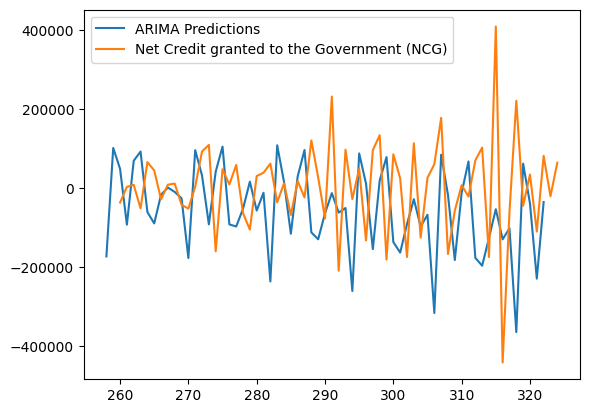

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=fitted_model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test.plot(legend=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test.mean()
rmse=sqrt(mean_squared_error(pred,test))
print(rmse)

158454.1578800574
